# PACKEGES & LIBRARIES

In [1]:
import os

import math
import matplotlib.pyplot as plt
import numpy as np

from skimage import io, transform, color, img_as_float, img_as_float64, img_as_ubyte
from scipy.ndimage import gaussian_filter
from skimage.filters import gaussian, rank
from skimage.morphology import disk

import cv2

import warnings
warnings.filterwarnings("ignore")

# plt.rcParams['figure.figsize'] = [15, 5]

SPAN = 15

# FUNCTION

In [2]:
def reconstruct_rgb_by_single_ycbcr_ch(y, cb, cr):
    ycbcbr_img = np.stack((y, cb, cr), axis=-1)
    rgb_img = color.ycbcr2rgb(ycbcbr_img)

    return img_as_float(rgb_img)

In [25]:
def show_img(img, colmap=False, dict_title=None):

    if isinstance(img, list):
        num_images = len(img)
        max_per_row = 3
        num_rows = math.ceil(num_images / max_per_row)
        plt.figure(figsize=(5 * max_per_row, 5 * num_rows))

        if dict_title and len(dict_title) != num_images:
            print("Warning: The number of titles does not match the number of images.")
            dict_title = None

        for i, single_img in enumerate(img, 1):
            plt.subplot(num_rows, max_per_row, i)
            if colmap:
                plt.imshow(single_img, norm='linear', cmap='gray')
            else:
                plt.imshow(single_img, norm='linear')
            plt.subplots_adjust(wspace=0.3, hspace=-0.3)

            title = dict_title.get(i, f"Image n. {i}") if dict_title else f"Image n. {i}"
            plt.title(title)

    else:
        plt.figure(figsize=(15, 5))
        if colmap:
            plt.imshow(img, norm='linear', cmap='gray')
        else:
            plt.imshow(img, norm='linear')
        plt.title("Custom image")

    plt.show()

# MAIN

First, I load a specific image saved by google images. Then, by using `skimage.color.convert_colorspace`, the image originally mapped in **RGB** color space, is going to be mapped in the new **YCbCr** domain.

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
mn_rgb = io.imread(os.path.join('./drive/MyDrive/Images/mountains.jpg'))
# mn_ycbcr = color.convert_colorspace(mn_rgb, 'RGB', 'YCbCr')
mn_ycbcr = color.rgb2ycbcr(mn_rgb)

In order to plot the YCbCr image recalling `matplotlib` methods, an 'int' casting to array values is performed as floats do not be supported if not scaled into the [0,1] range.

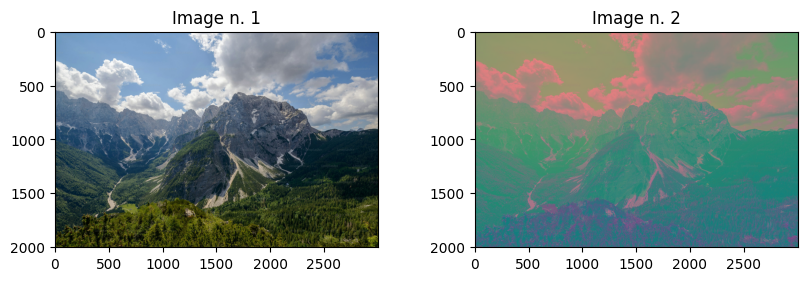

In [14]:
mn_ycbcr_int = mn_ycbcr.astype(int) # 'int' casting
show_img([mn_rgb, mn_ycbcr_int])

The above graph is just the comparison of the two color spaces: while the original is mapped in RGB space by default, the second is made by overlapping each of the 3 color-channel, namely the **Luma** (*Y*) channel - a kind of grayscale mapping - and both the **chroma** channels (*Cb* and *Cr* ).

Let's now compare the shapes of the two different color-domain images:

In [15]:
print("Shape of rgb img: ", mn_rgb.shape)
print("Shape of ycbcr img: ", mn_ycbcr.shape)

Shape of rgb img:  (2002, 3000, 3)
Shape of ycbcr img:  (2002, 3000, 3)


It can be noticed that no transformation regarding array dimensions it has been performed.<br>
Color channels are either of the same amount (three).

## Y-Cb-Cr image exploration

Let's now split each of the YCbCr channels, in order to plot them one by one.

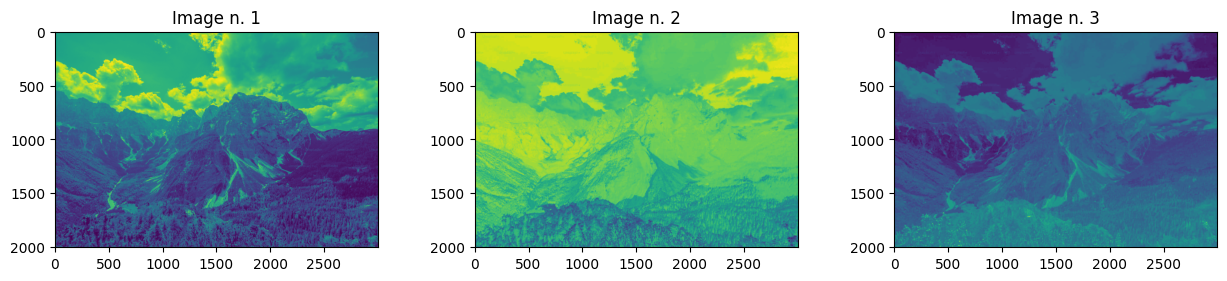

In [16]:
show_img([mn_ycbcr[:, :, 0],mn_ycbcr[:, :, 1],mn_ycbcr[:, :, 2]])

Let's plot the same single-channel YCbCr images, by applying the grayscale color map

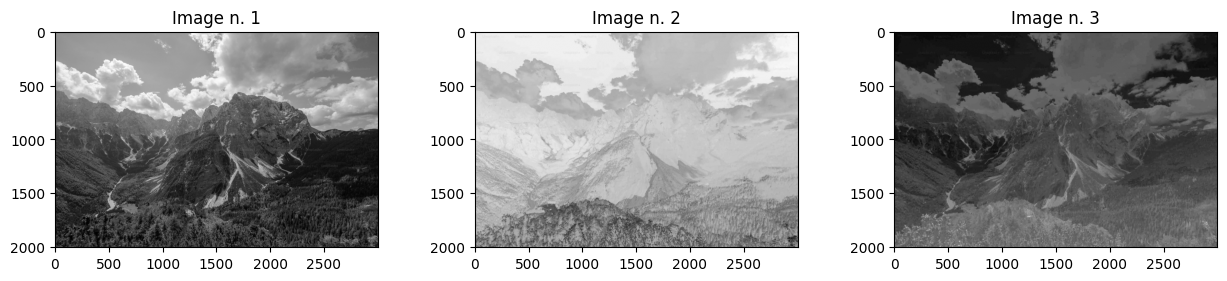

In [20]:
show_img([mn_ycbcr[:, :, 0],mn_ycbcr[:, :, 1],mn_ycbcr[:, :, 2]], colmap=True)

In [18]:
mn_ycbcr[:, :, 0] # example of single 2D matrix, by choosing Luma channel-valued pixels

array([[137.34317647, 138.202     , 139.06082353, ...,  91.46052941,
         91.46052941,  91.46052941],
       [136.48435294, 137.34317647, 139.06082353, ...,  91.46052941,
         91.46052941,  91.46052941],
       [136.48435294, 137.34317647, 138.202     , ...,  91.46052941,
         91.46052941,  91.46052941],
       ...,
       [ 74.327     ,  82.01003529, 125.05427059, ...,  30.70477647,
         75.12484706,  74.28062353],
       [ 89.96274118,  95.65674118,  96.80928235, ...,  36.78267059,
         43.98562353,  59.96317647],
       [ 90.55532941,  83.21754118,  74.5022    , ...,  33.17389412,
         40.97888235,  56.64811765]])

By extracting the single channel-index, it is possibile to plot a 2D numpy.array, where each single pixel is mapped onto it.

## Gaussian filter

In [21]:
cb_only = mn_ycbcr[:,:,1] # extracting 'Cb' channel
cr_only = mn_ycbcr[:,:,2] # extracting 'Cr' channel

Let's now build the blurred channel-specific image, by chosing sigma=10.<br>
By reading `skimage` documentation, `gaussian` method implemented by `filters` class wraps `scipy.ndimage.gaussian_filter()` function: as it provides more paramaters to be defined, I decide to use the source code for processing.<br>
The two code cells below are related to some trials of performing gaussian filter on **chroma** channels, with different values of *sigma*.

In [22]:
cb_only_gf_1a = gaussian_filter(cb_only, sigma=3); cr_only_gf_1a = gaussian_filter(cr_only, sigma=3)
cb_only_gf_1b = gaussian_filter(cb_only, sigma=5); cr_only_gf_1b = gaussian_filter(cr_only, sigma=5)
cb_only_gf_1c = gaussian_filter(cb_only, sigma=9); cr_only_gf_1c = gaussian_filter(cr_only, sigma=9)
cb_only_gf_1d = gaussian_filter(cb_only, sigma=15); cr_only_gf_1d = gaussian_filter(cr_only, sigma=15)
cb_only_gf_1e = gaussian_filter(cb_only, sigma=20); cr_only_gf_1e = gaussian_filter(cr_only, sigma=20)
cb_only_gf_1f = gaussian_filter(cb_only, sigma=30); cr_only_gf_1f = gaussian_filter(cr_only, sigma=30)

In order to display how blurred images appear by using different *sigma* values, I plot as an example th **Cb** processed-image only among the six different choices of value

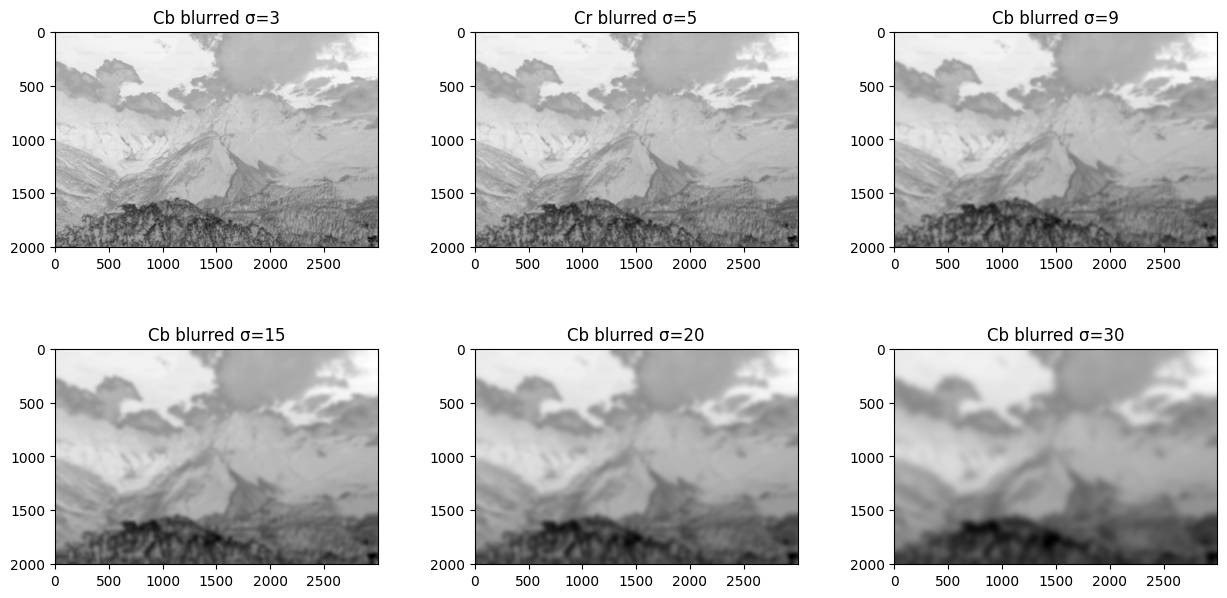

In [26]:
subplot_titles = {
    1: "Cb blurred σ=3",
    2: "Cr blurred σ=5",
    3: "Cb blurred σ=9",
    4: "Cb blurred σ=15",
    5: "Cb blurred σ=20",
    6: "Cb blurred σ=30"
}

show_img([cb_only_gf_1a,cb_only_gf_1b,
          cb_only_gf_1c,cb_only_gf_1d,
          cb_only_gf_1e,cb_only_gf_1f],
          colmap=True,
          dict_title=subplot_titles)

As it can be revealed by plots, the greater the values of **sigma**, the greater the effect of filter blurring.<br>
About **radius** parameter which manages the kernel size:
* if specified, radius takes a value equal to (2*k + 1), with k=custom value;
* otherwise, it takes the default value of (4*σ).

For the aim of the asseignement, parameters which leads to *1b* and *1f*  will be taken into account.

In [ ]:
print(cr_only); print("---"*SPAN*3, '\n'); print(cr_only_gf_1f)

[[105.88883922 105.88883922 105.88883922 ... 108.03479216 108.03479216
  108.03479216]
 [105.88883922 105.88883922 105.88883922 ... 108.03479216 108.03479216
  108.03479216]
 [105.88883922 105.88883922 105.88883922 ... 108.03479216 108.03479216
  108.03479216]
 ...
 [132.43915294 131.84643137 130.51813333 ... 128.55011765 131.85708235
  131.84643137]
 [129.80385882 128.78257255 128.5682902  ... 127.87531765 128.88595294
  128.50751373]
 [128.11842353 127.83271373 127.92544314 ... 127.37532549 127.9467451
  127.79323922]]
--------------------------------------------------------------------------------------------------------------------------------------- 

[[106.07552715 106.0758092  106.07637284 ... 108.042217   108.04221254
  108.04221189]
 [106.07566205 106.07594445 106.0765088  ... 108.04239182 108.04238785
  108.04238745]
 [106.0759312  106.07621431 106.07678007 ... 108.04273996 108.04273698
  108.04273707]
 ...
 [128.78410826 128.78456629 128.78548224 ... 127.04482797 127.0416862

Above it can be noticed how filter acts, with the smoothing behavior especially towards the right-down values: from [119, 104, 101, 116, 112, 109, 119, 115, 113] -> [112,...,112].

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2513838039260839..1.1269232679324301].


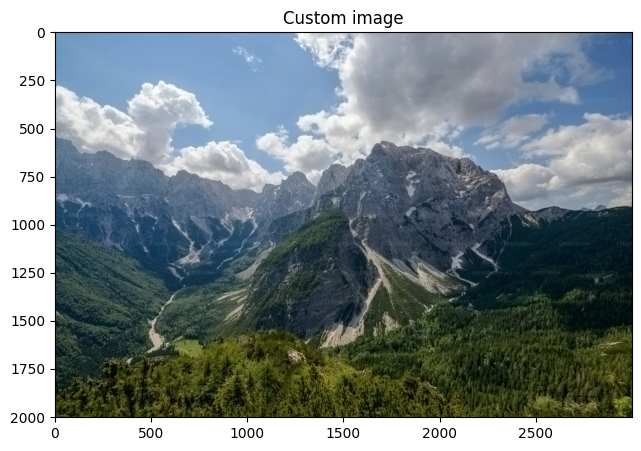

In [ ]:
rgb_rebuilt_img_chroma_blr = reconstruct_rgb_by_single_ycbcr_ch(
                mn_ycbcr[:,:,0],
                cb_only_gf_1e,
                cr_only_gf_1e)

show_img(rgb_rebuilt_img_chroma_blr)

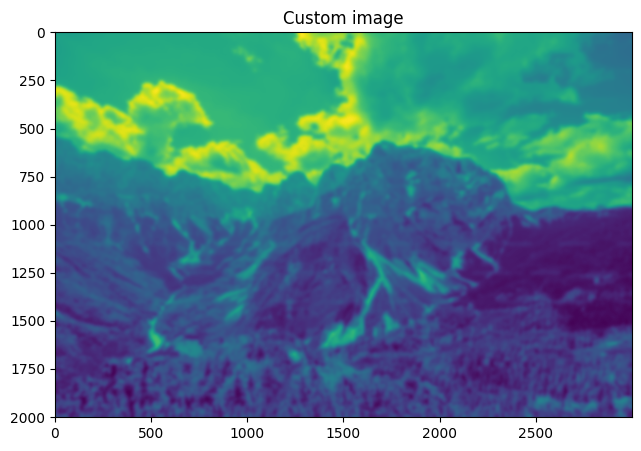

In [ ]:
Y_blurred = gaussian_filter(mn_ycbcr[:,:,0], sigma=9)
show_img(Y_blurred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2847793430688658..0.9902623959485088].


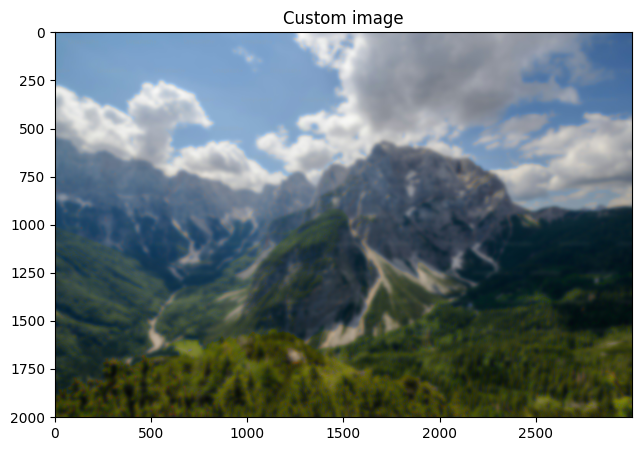

In [ ]:
rgb_rebuilt_img_luma_blr = reconstruct_rgb_by_single_ycbcr_ch(
                Y_blurred, cb_only, cr_only)

show_img(rgb_rebuilt_img_luma_blr)

## Mean filter

In [ ]:
cb_normalized = (cb_only - cb_only.min()) / (cb_only.max() - cb_only.min())
cb_uint8 = img_as_ubyte(cb_normalized)

cr_normalized = (cr_only - cr_only.min()) / (cr_only.max() - cr_only.min())
cr_uint8 = img_as_ubyte(cr_normalized)

luma_ch = mn_ycbcr[:,:,0]
luma_ch_normalized = (luma_ch - luma_ch.min()) / (luma_ch.max() - luma_ch.min())
luma_ch_uint8 = img_as_ubyte(luma_ch_normalized)

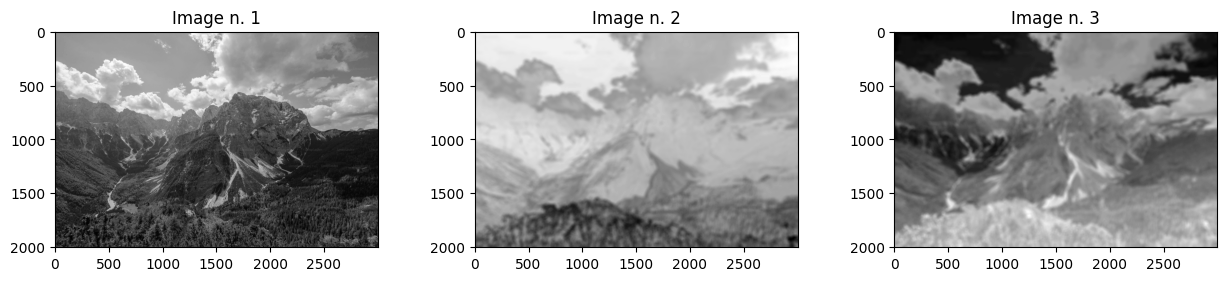

In [ ]:
footp = disk(20)
luma_ch_mean_flt = rank.mean(luma_ch_uint8, footprint=footp)
cb_only_mean_flt = rank.mean(cb_uint8, footprint=footp)
cr_only_mean_flt = rank.mean(cr_uint8, footprint=footp)
show_img([mn_ycbcr[:,:,0], cb_only_mean_flt,cr_only_mean_flt], colmap=True)

In [ ]:
mn_rgb_mean_flt = reconstruct_rgb_by_single_ycbcr_ch(
                  mn_ycbcr[:,:,0],
                  cb_only_mean_flt,
                  cr_only_mean_flt
                )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5185290231697113..1.7286603214706897].


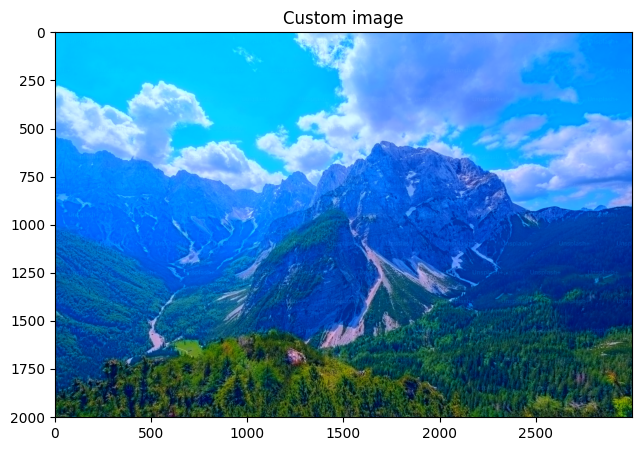

In [ ]:
show_img(mn_rgb_mean_flt)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.34418055331721725..1.07487574536664].


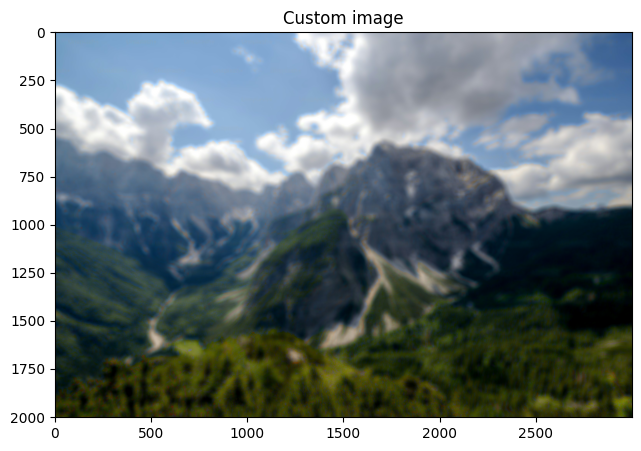

In [ ]:
mn_rgb_mean_flt = reconstruct_rgb_by_single_ycbcr_ch(
                  luma_ch_mean_flt,
                  cb_only,
                  cr_only
                )

show_img(mn_rgb_mean_flt)

In [ ]:
onlyCb_sk = mn_ycbcr.copy()
onlyCr_sk = mn_ycbcr.copy()